# Extracting Positional Matrices from BERT:

## Explanation and Data Preparation:

### Introduction:

A positional statement is a sentence of the form: ‘A is at the left of B’. Now the explicit information convoyed by this statement is that A is at the left of the B object, and this is easily represented by the vector $V(S_1)$, however, there is also another type of information, that is not explicitly stated, but that is there. This information is the inverse relation between the two objects: ‘B is at the right of A’. This type of information can seem trivial for humans, as (i would infer) it is always accounted by a different module from the language brain area.

I would say that humans do not need to explicitly state the inverse information, as it is always implicitly represented by their acknowledgment of their position in the space(embodied). Indeed, humans have a body in space, and that is enough for they to always derive the inverse information in positional statements. Although we cannot say that in regard of LLMs, where the whole information available to a model must be represented by a vector.

Now, if the simple case of reverse information can seem trivial. We can observe how its complexity can increase exponentially with the increase of number of statements

### Data Preparation:

In [1]:
import numpy as np
import pandas as pd

In [ ]:
pip install transformers torch

In [3]:
import torch
from transformers import BertTokenizer, BertModel

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
sentences_data = pd.read_csv('/content/drive/MyDrive/BERT/data_bert_extraction - data_bert_extraction.csv', sep=',')

Preparation of the dataset:

In [6]:
sentences_data['Spatial_rel'] = 'left of'

In [7]:
sentences_data.loc[50:, 'Spatial_rel'] = 'right_of'

In [8]:
sentences_data.head()

,Sentence,Entity_1,Entity_2,Spatial_rel
0,The clock is left of the painting.,The clock,The painting,left of
1,A tree is left of the building.,A tree,The building,left of
2,The lamp is left of the television.,The lamp,The television,left of
3,A cat is sitting left of the dog.,A cat,The dog,left of
4,The coffee cup is left of the computer.,The coffee cup,the computer,left of


Encoding spatial relationships for Probing

In [9]:
# label encoder:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
sentences_data['SR_label'] = label_encoder.fit_transform(sentences_data['Spatial_rel'])

In [10]:
sentences_data.head()

,Sentence,Entity_1,Entity_2,Spatial_rel,SR_label
0,The clock is left of the painting.,The clock,The painting,left of,0
1,A tree is left of the building.,A tree,The building,left of,0
2,The lamp is left of the television.,The lamp,The television,left of,0
3,A cat is sitting left of the dog.,A cat,The dog,left of,0
4,The coffee cup is left of the computer.,The coffee cup,the computer,left of,0


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
def get_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :]


sentences_data['Bert_embeddings'] = sentences_data['Sentence'].apply(get_bert_embeddings)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = np.vstack(sentences_data['Bert_embeddings'])
y = sentences_data['SR_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)


accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.95


Find the Most informative layer for spatial relationships

In [14]:
def get_cumulative_embeddings(sentences, max_layer):
    cumulative_embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        layer_embeddings = torch.sum(torch.stack(outputs.hidden_states[:max_layer + 1]), dim=0)
        cumulative_embeddings.append(layer_embeddings[:, 0, :])  # Using [CLS] token
    return torch.vstack(cumulative_embeddings).numpy()

scores = []

for layer in range(bert_model.config.num_hidden_layers):

    X = get_cumulative_embeddings(sentences_data['Sentence'], layer)
    y = sentences_data['SR_label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)


    score = clf.score(X_test, y_test)
    scores.append(score)
    print(f"Layer {layer + 1}, Accuracy: {score}")


diff_scores = [scores[i] - scores[i-1] for i in range(1, len(scores))]


most_informative_layer = diff_scores.index(max(diff_scores)) + 1
print(f"Most informative layer: {most_informative_layer}")


Layer 1, Accuracy: 0.4
Layer 2, Accuracy: 0.95
Layer 3, Accuracy: 0.95
Layer 4, Accuracy: 0.95
Layer 5, Accuracy: 1.0
Layer 6, Accuracy: 1.0
Layer 7, Accuracy: 1.0
Layer 8, Accuracy: 1.0
Layer 9, Accuracy: 1.0
Layer 10, Accuracy: 0.95
Layer 11, Accuracy: 0.95
Layer 12, Accuracy: 0.95
Most informative layer: 1


Create Embeddings from BERT

In [15]:
tokenized = sentences_data['Sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [16]:
from keras.preprocessing.sequence import pad_sequences

In [17]:
MAX_LEN = 64
input_ids = pad_sequences(tokenized.values, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [18]:
inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)

In [19]:
with torch.no_grad():
    outputs = bert_model(inputs, attention_mask=masks)

In [20]:
final_s_embeddings = outputs.last_hidden_state

In [21]:
ar = np.array(final_s_embeddings)

In [22]:
print(np.shape(ar))

(100, 64, 768)


## Probing positional stat in BERT

Since we are interest in analysing the positional statements in BERT, we need not to operate on the full final embedding, but only in the ones that represent *spatial relationships* between entities.

In [23]:
features_list = []
targets_list = []

for index, row in sentences_data.iterrows():

    inputs_phrase = tokenizer(row['Sentence'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_phrase = bert_model(**inputs_phrase)
    embedding_phrase = outputs_phrase.last_hidden_state.mean(dim=1)
    targets_list.append(embedding_phrase)

    # Processing for Entity 1
    inputs_entity1 = tokenizer(row['Entity_1'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_entity1 = bert_model(**inputs_entity1)
    embedding_entity1 = outputs_entity1.last_hidden_state.mean(dim=1)

    # Processing for Entity 2
    inputs_entity2 = tokenizer(row['Entity_2'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_entity2 = bert_model(**inputs_entity2)
    embedding_entity2 = outputs_entity2.last_hidden_state.mean(dim=1)


    combined_embedding = torch.cat((embedding_entity1, embedding_entity2), dim=1)
    features_list.append(combined_embedding)


features_tensor = torch.cat(features_list, dim=0)
targets_tensor = torch.cat(targets_list, dim=0)

## NN for matrix extraction:

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim


In [25]:


class TransformationNet(nn.Module):
    def __init__(self, input_size, intermediate_size, output_size):
        super(TransformationNet, self).__init__()
        self.reducer = nn.Linear(input_size, intermediate_size)
        self.transformer = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        x = self.reducer(x)
        x = self.transformer(x)
        return x


input_size = 1536
intermediate_size = 768
output_size = 768
model = TransformationNet(input_size, intermediate_size, output_size)




In [26]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CosineEmbeddingLoss()


num_epochs = 50
batch_size = 16


dataset = torch.utils.data.TensorDataset(features_tensor, targets_tensor)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch_features, batch_targets in data_loader:

        outputs = model(batch_features)

        loss = loss_fn(outputs, batch_targets, torch.ones(batch_targets.size(0)))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.2028
Epoch [2/50], Loss: 0.1736
Epoch [3/50], Loss: 0.1444
Epoch [4/50], Loss: 0.1017
Epoch [5/50], Loss: 0.1248
Epoch [6/50], Loss: 0.1218
Epoch [7/50], Loss: 0.1272
Epoch [8/50], Loss: 0.1058
Epoch [9/50], Loss: 0.0658
Epoch [10/50], Loss: 0.0990
Epoch [11/50], Loss: 0.0834
Epoch [12/50], Loss: 0.0745
Epoch [13/50], Loss: 0.0701
Epoch [14/50], Loss: 0.0798
Epoch [15/50], Loss: 0.0729
Epoch [16/50], Loss: 0.0982
Epoch [17/50], Loss: 0.0591
Epoch [18/50], Loss: 0.0776
Epoch [19/50], Loss: 0.0558
Epoch [20/50], Loss: 0.0455
Epoch [21/50], Loss: 0.0485
Epoch [22/50], Loss: 0.0365
Epoch [23/50], Loss: 0.0621
Epoch [24/50], Loss: 0.0453
Epoch [25/50], Loss: 0.0338
Epoch [26/50], Loss: 0.0500
Epoch [27/50], Loss: 0.0716
Epoch [28/50], Loss: 0.0574
Epoch [29/50], Loss: 0.0416
Epoch [30/50], Loss: 0.0274
Epoch [31/50], Loss: 0.0340
Epoch [32/50], Loss: 0.0744
Epoch [33/50], Loss: 0.0291
Epoch [34/50], Loss: 0.0768
Epoch [35/50], Loss: 0.0328
Epoch [36/50], Loss: 0.0358
E

In [27]:
# Extract the weights from the linear layer of the model
transformation_matrix = model.transformer.weight.detach().numpy()


In [28]:
test_df = pd.read_csv('/content/drive/MyDrive/BERT/test_bert.csv')

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

test_features_list = []
test_targets_list = []


for index, row in test_df.iterrows():

    inputs_phrase = tokenizer(row['Sentence'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_phrase = bert_model(**inputs_phrase)
    embedding_phrase = outputs_phrase.last_hidden_state.mean(dim=1)
    test_targets_list.append(embedding_phrase)


    inputs_entity1 = tokenizer(row['Entity_1'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_entity1 = bert_model(**inputs_entity1)
    embedding_entity1 = outputs_entity1.last_hidden_state.mean(dim=1)


    inputs_entity2 = tokenizer(row['Entity_2'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_entity2 = bert_model(**inputs_entity2)
    embedding_entity2 = outputs_entity2.last_hidden_state.mean(dim=1)


    combined_embedding = torch.cat((embedding_entity1, embedding_entity2), dim=1)
    test_features_list.append(combined_embedding)


features_tensor = torch.cat(test_features_list, dim=0)
targets_tensor = torch.cat(test_targets_list, dim=0)


with torch.no_grad():
    transformed_vectors = model(features_tensor)

transformed_vectors_np = transformed_vectors.numpy()
targets_tensor_np = targets_tensor.numpy()

similarities = cosine_similarity(transformed_vectors_np, targets_tensor_np)

diagonal_similarities = np.diag(similarities)


similarity_df = pd.DataFrame(diagonal_similarities, columns=['Cosine Similarity'])


average_similarity = similarity_df['Cosine Similarity'].mean()
print("Average Cosine Similarity:", average_similarity)

Average Cosine Similarity: 0.91630125


### Plotting

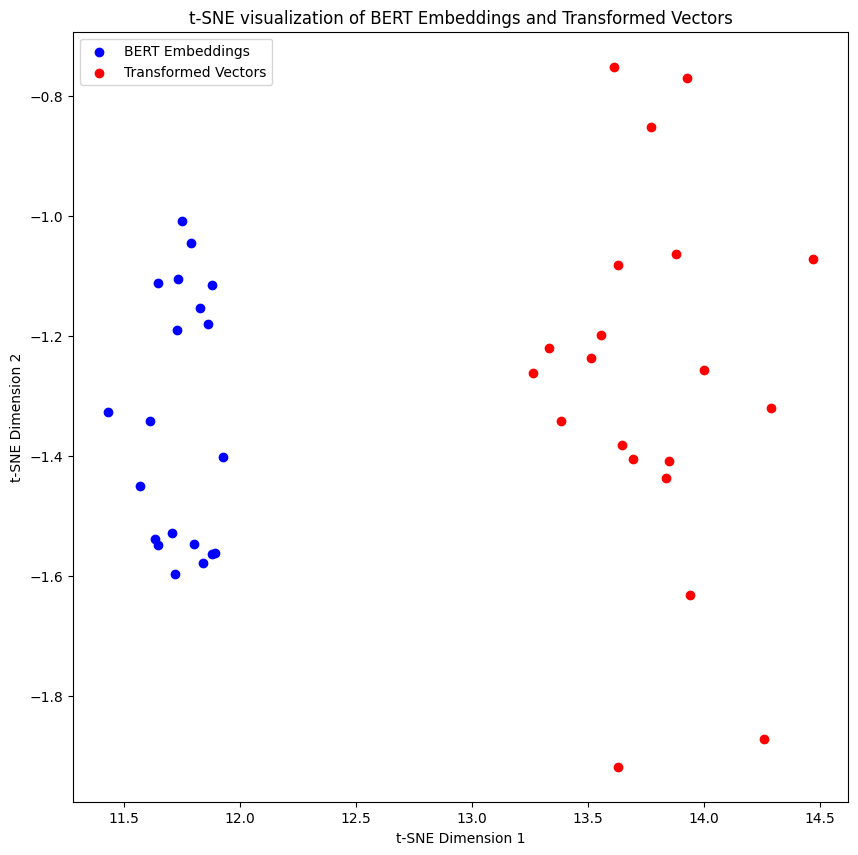

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


bert_embeddings = targets_tensor.detach().numpy()
transformed_embeddings = transformed_vectors.detach().numpy()


all_vectors = np.concatenate([bert_embeddings, transformed_embeddings])


tsne = TSNE(n_components=2, random_state=0)
reduced_vectors = tsne.fit_transform(all_vectors)


reduced_bert_embeddings = reduced_vectors[:len(bert_embeddings)]
reduced_transformed_embeddings = reduced_vectors[len(bert_embeddings):]


plt.figure(figsize=(10, 10))
plt.scatter(reduced_bert_embeddings[:, 0], reduced_bert_embeddings[:, 1], color='blue', label='BERT Embeddings')
plt.scatter(reduced_transformed_embeddings[:, 0], reduced_transformed_embeddings[:, 1], color='red', label='Transformed Vectors')
plt.legend()
plt.title('t-SNE visualization of BERT Embeddings and Transformed Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


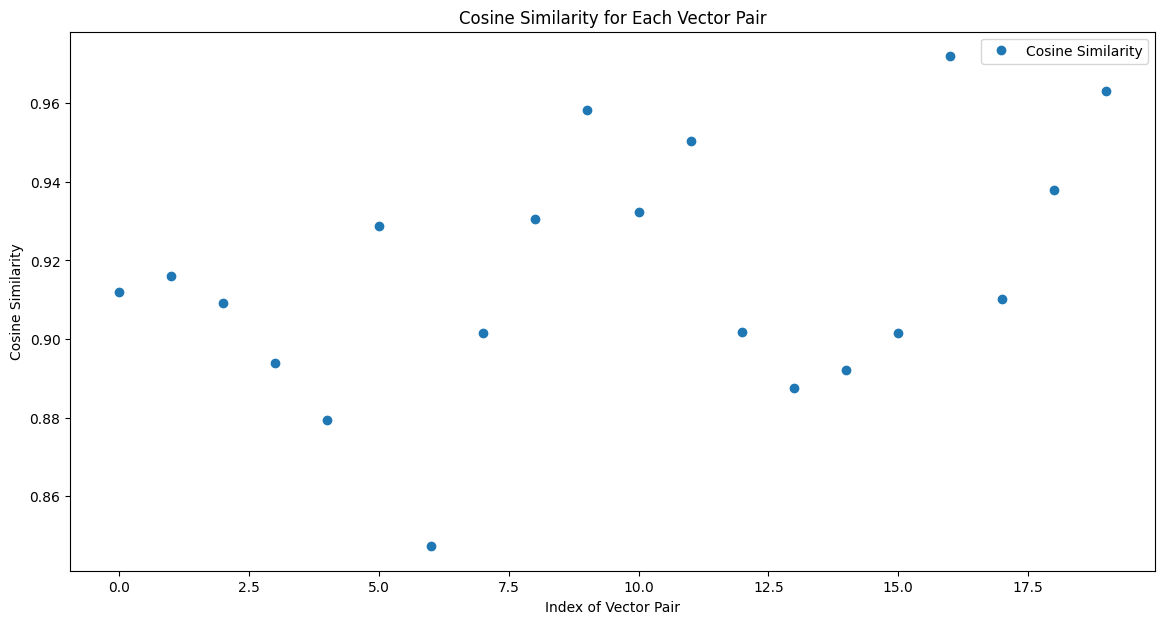

In [31]:
import matplotlib.pyplot as plt


indices = range(len(diagonal_similarities))
plt.figure(figsize=(14, 7))
plt.plot(indices, diagonal_similarities, 'o', label='Cosine Similarity')
plt.title('Cosine Similarity for Each Vector Pair')
plt.xlabel('Index of Vector Pair')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()


## Inverting the Matrix:

In [32]:
np.shape(transformation_matrix)

(768, 768)

## Testing inversion:

In [36]:
# Since the NN arichtechture was designed for obtaining a square matrix, we
# can easily invert it:

inverse_matrix = np.linalg.inv(transformation_matrix)
#inverse_matrix = transformation_matrix * -1


In [37]:
# Calculate the condition number
cond_number = np.linalg.cond(transformation_matrix)
print("Condition number of the matrix:", cond_number)

# Inspect the result
print("Resulting matrix:", result)

# Check if using higher precision helps
transformation_matrix = np.array(transformation_matrix, dtype=np.float64)
inverse_matrix = np.linalg.inv(transformation_matrix)
result = transformation_matrix.dot(inverse_matrix)
is_identity_high_precision = np.allclose(result, np.eye(transformation_matrix.shape[0]), atol=1e-8)
print("Is the product an identity matrix with higher precision?", is_identity_high_precision)


Condition number of the matrix: 129404.414
Resulting matrix: [[ 1.0000029e+00 -2.8610229e-06  3.3378601e-06 ...  7.1525574e-07
   4.7683716e-07  7.6293945e-06]
 [ 3.8146973e-06  1.0000057e+00 -1.9073486e-06 ...  2.3841858e-07
  -1.9073486e-06  3.8146973e-06]
 [ 0.0000000e+00  1.9073486e-06  1.0000062e+00 ... -1.0728836e-06
  -2.3841858e-07  9.5367432e-06]
 ...
 [-3.8146973e-06  9.5367432e-07 -1.9073486e-06 ...  1.0000005e+00
   0.0000000e+00 -7.6293945e-06]
 [-1.3351440e-05  7.6293945e-06 -5.7220459e-06 ...  9.5367432e-07
   1.0000029e+00  3.8146973e-05]
 [ 1.3351440e-05 -7.6293945e-06 -2.8610229e-06 ... -9.5367432e-07
   9.5367432e-07  1.0000038e+00]]
Is the product an identity matrix with higher precision? True


### Replacing weights in NN: process new entities and measure similarity with sentence

In [38]:
right_data = pd.read_csv('/content/drive/MyDrive/BERT/right_ofData - Sheet1.csv')

## Testing if the NN with the new weigh matrix (symmetrical) produces the embeddings similar to BERT for the same spatial relationship:

In [39]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


right_features_list = []
right_targets_list = []

reduction_layer = nn.Linear(1536, 768)

for index, row in right_data.iterrows():

    inputs_phrase = tokenizer(row['Sentence'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_phrase = bert_model(**inputs_phrase)
    embedding_phrase = outputs_phrase.last_hidden_state.mean(dim=1)
    right_targets_list.append(embedding_phrase)

    # Processing for Entity 1
    inputs_entity1 = tokenizer(row['Entity_1'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_entity1 = bert_model(**inputs_entity1)
    embedding_entity1 = outputs_entity1.last_hidden_state.mean(dim=1)

    # Processing for Entity 2
    inputs_entity2 = tokenizer(row['Entity_2'], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs_entity2 = bert_model(**inputs_entity2)
    embedding_entity2 = outputs_entity2.last_hidden_state.mean(dim=1)

    combined_embedding = torch.cat((embedding_entity1, embedding_entity2), dim=1)


    reduced_embedding = reduction_layer(combined_embedding)

    transformed_embedding = torch.matmul(reduced_embedding, torch.tensor(inverse_matrix, dtype=torch.float))

    right_features_list.append(transformed_embedding)
    right_targets_list.append(embedding_phrase)


right_features_tensor = torch.stack(right_features_list)
right_targets_tensor = torch.stack(right_targets_list)

right_features_2d = right_features_tensor.squeeze().detach().numpy()
right_targets_2d = right_targets_tensor.squeeze().detach().numpy()

cos_similarities = cosine_similarity(right_features_2d, right_targets_2d)


diagonal_similarities = np.diag(cos_similarities)
average_similarity = np.mean(diagonal_similarities)
print(f"Average Cosine Similarity: {average_similarity:.4f}")


Average Cosine Similarity: 0.0052
